In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import plotly.express as px

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

import keras_tuner
from keras_tuner.tuners import RandomSearch
from pickle import dump
from sklearn.metrics import f1_score

In [246]:
df = pd.read_csv("data/final.csv")

In [248]:
pd.set_option('display.max_columns', None)

In [249]:
df = df.drop(['Topic:', 'Url', "Title", "Global Rank", "Alexa USA Rank", "Alexa Reach Rank",
              "Domain Age", "HTTP Response Codes:", "Canonical URL", "Root IP", "nb_or", "whois_r",
              "nb_star", "nb_dollar", "nb_comma", "path_ext", "nb_space", "url", "status_x", "nb_brand",
              "Trust Flow", "cPR Score", "Domain Authority", "Page Authority","Referring Domains",
              'GOV Domains', 'GOV Backlinks', 'EDU Domains', "nb_brand"], axis=1)

#df = df.drop(['Topic:', "Title", "Global Rank", "Alexa USA Rank", "Alexa Reach Rank",
#              "Domain Age", "HTTP Response Codes:", "Root IP", "status_x",
#              "Trust Flow", "cPR Score", "Domain Authority", "Page Authority","Referring Domains",
#             'GOV Domains', 'GOV Backlinks', 'EDU Domains'], axis=1)


In [250]:
df.drop(df[df['Trust Metric'] == "Trust Metric:"].index, inplace=True)

In [251]:
def clean(key, column):
    df[column] = df[column].astype(str)
    new_column = []
    for row in df[column]:
        n_row = row.replace(key, "")
        new_column.append(n_row)
    df[column] = np.array(new_column, dtype=str)

clean("/10", "Google PageRank")
clean(" / 18", "Spam Score")
clean(",", "External Backlinks")
clean(",", "Indexed URLs")
clean(",", "EDU Backlinks")

In [252]:
df['status_y'].replace(['legitimate', 'phishing'], [0, 1], inplace=True)

In [287]:
numerical = ['Google PageRank','Trust Metric', 'Citation Flow', 'Spam Score', 'External Backlinks', 'EDU Backlinks',
             'Topic Value', 'Indexed URLs', "has_ip", "url_len", "is_short", "nb_semico", "nb_dslash", "nb_slash",
             "nb_colon", "nb_tilde", "abn_sd", "nb_sd", "nb_dot", "nb_at",
             "nb_and", "nb_equal", "nb_excl", "nb_uscore", "nb_hyphens", "d_ratio", "domain_s", "domain_e",
             "count_https", "nb_hint",]

catagorical = ['Domain Validity', 'PR Quality', "Crawled Flag", 'Google Directory listed', 'DMOZ.org listed']

In [262]:
df.columns

Index(['has_ip', 'url_len', 'is_short', 'nb_semico', 'nb_dslash', 'nb_slash',
       'nb_colon', 'nb_tilde', 'abn_sd', 'nb_sd', 'nb_dot', 'nb_at', 'nb_and',
       'nb_equal', 'nb_excl', 'nb_uscore', 'nb_hyphens', 'd_ratio', 'domain_s',
       'domain_e', 'count_https', 'nb_hint', 'status_y', 'Google PageRank',
       'Trust Metric', 'Citation Flow', 'Domain Validity', 'Spam Score',
       'External Backlinks', 'EDU Backlinks', 'PR Quality',
       'Google Directory listed', 'DMOZ.org listed', 'Topic Value',
       'Indexed URLs', 'Crawled Flag'],
      dtype='object')

In [263]:
df = df[['has_ip', 'url_len', 'is_short', 'nb_semico', 'nb_dslash', 'nb_slash',
       'nb_colon', 'nb_tilde', 'abn_sd', 'nb_sd', 'nb_dot', 'nb_at', 'nb_and',
       'nb_equal', 'nb_excl', 'nb_uscore', 'nb_hyphens', 'd_ratio', 'domain_s',
       'domain_e', 'count_https', 'nb_hint', 'Google PageRank',
       'Trust Metric', 'Citation Flow', 'Domain Validity', 'Spam Score',
       'External Backlinks', 'EDU Backlinks', 'PR Quality',
       'Google Directory listed', 'DMOZ.org listed', 'Topic Value',
       'Indexed URLs', 'Crawled Flag', 'status_y']]

In [264]:
df[numerical] = df[numerical].astype(float)

In [265]:
def outlier(col, df):
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    lower_bound = df[col].quantile(0.25) - (IQR * 1.5)
    upper_bound = df[col].quantile(0.75) + (IQR * 1.5)
    print(f"The outliers in {col} feature are values << {lower_bound} and >> {upper_bound}")
    minimum = df[col].min()
    maximum = df[col].max()
    print(f"The minimum value in {col} is {minimum} and maximum value is {maximum}")
    
    fig = px.box(df,y=col, width=800,title='Before capping the outliers')
    #fig.show()
    
    df[col] = np.where(df[col]>upper_bound,upper_bound,df[col])
    
    fig = px.box(df,y=col, width=800,title='After capping the outliers')
    #fig.show()
    
outlier("url_len", df)

The outliers in url_len feature are values << -25.5 and >> 130.5
The minimum value in url_len is 12.0 and maximum value is 130.5


In [266]:
corr_matrix = df.corr()
corr_matrix["status_y"].sort_values(ascending=False)

status_y              1.000000
url_len               0.308620
has_ip                0.308383
nb_hint               0.302603
nb_excl               0.293061
nb_slash              0.241622
d_ratio               0.233161
nb_equal              0.232122
nb_dot                0.210053
Spam Score            0.186673
nb_and                0.168266
nb_at                 0.140028
is_short              0.108583
nb_sd                 0.106193
nb_semico             0.100421
nb_colon              0.091791
abn_sd                0.089981
nb_dslash             0.069946
count_https           0.057687
nb_uscore             0.034312
nb_tilde              0.022796
EDU Backlinks        -0.054296
Indexed URLs         -0.084024
nb_hyphens           -0.100571
External Backlinks   -0.111881
domain_e             -0.165625
domain_s             -0.359949
Trust Metric         -0.505295
Topic Value          -0.524873
Google PageRank      -0.565753
Citation Flow        -0.612356
Name: status_y, dtype: float64

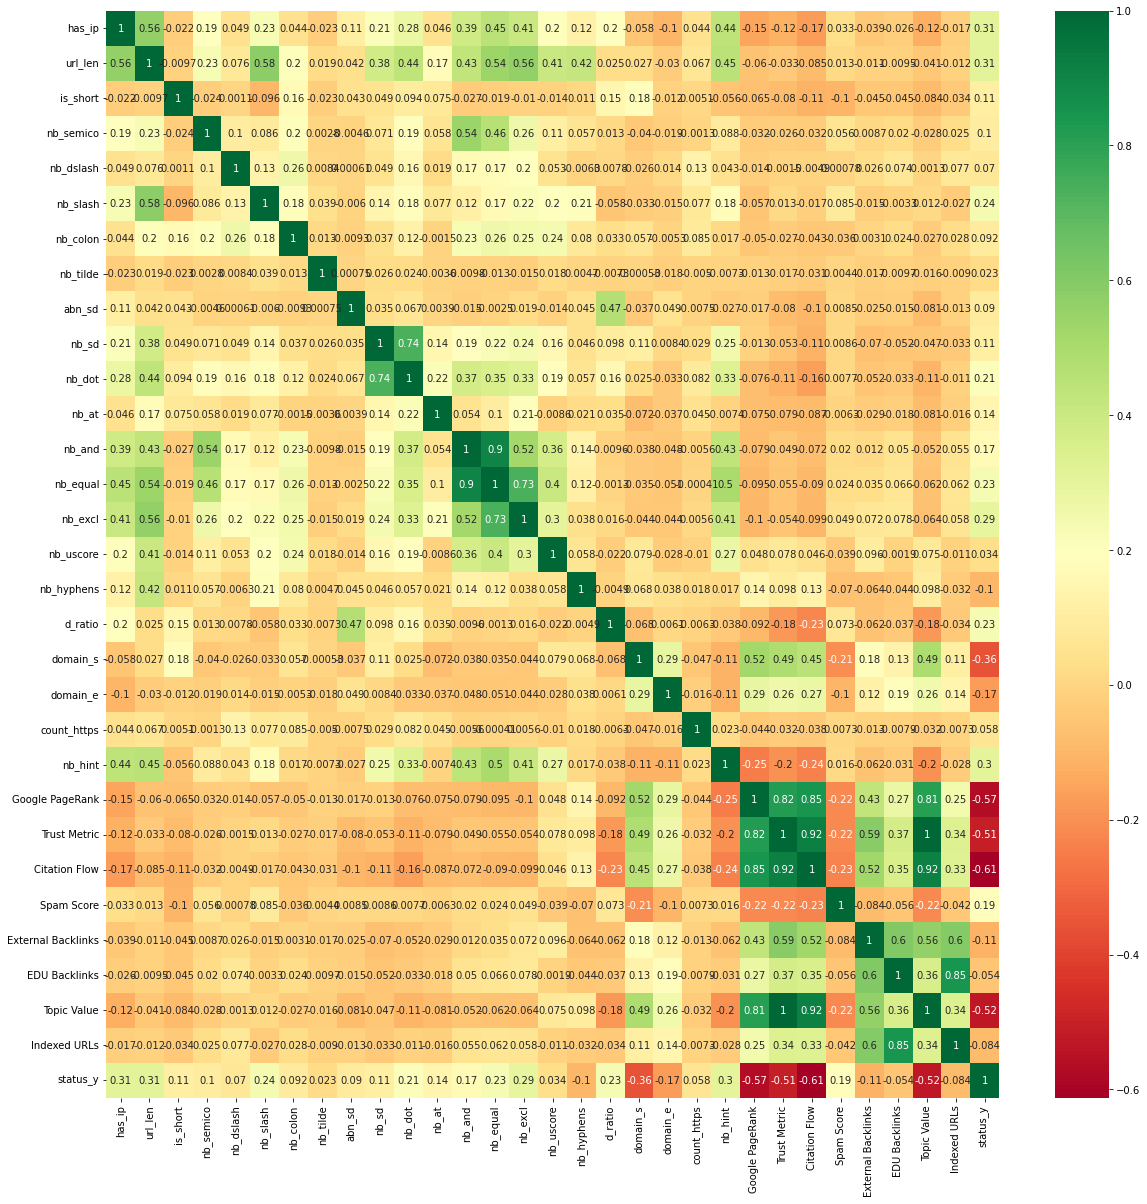

In [267]:
import seaborn as sns
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [268]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1].values

In [269]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [270]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
                        ("std_scaler", StandardScaler())
                        ])

In [271]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

full_pipeline = ColumnTransformer([("numerical", num_pipeline, numerical),
                                   ("catagorical", OneHotEncoder(handle_unknown='ignore'), catagorical)])

In [272]:
X_trainp = full_pipeline.fit_transform(X_train)
X_testp = full_pipeline.transform(X_test)
#X_a = full_pipeline.transform(df3)

In [273]:
dump(full_pipeline, open('output/pipeline.pkl', 'wb'))

In [274]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0, max_iter=250)
model.fit(X_trainp, y_train)

LogisticRegression(max_iter=250, random_state=0)

In [275]:
model.score(X_trainp, y_train)

0.9205943246863963

In [276]:
model.score(X_testp, y_test)

0.9170927684441198

In [277]:
n_features = X_trainp.shape[1]
# define model
model = Sequential()

model.add(Dense(256, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
#model.summary()

In [278]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 256)               10752     
                                                                 
 batch_normalization_37 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_35 (Dropout)        (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_38 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 256)              

In [279]:
#decayed_lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, 10000, 0.95,  staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [280]:
history = model.fit(X_trainp, y_train, epochs=60, batch_size=64, verbose=2, validation_data=(X_testp, y_test))#, callbacks=[earlyStopping, checkpoint]) #, reduce_lr_loss])

Epoch 1/60
129/129 - 1s - loss: 0.4178 - accuracy: 0.8199 - val_loss: 0.2513 - val_accuracy: 0.9021 - 1s/epoch - 8ms/step
Epoch 2/60
129/129 - 0s - loss: 0.2861 - accuracy: 0.8899 - val_loss: 0.2382 - val_accuracy: 0.9149 - 286ms/epoch - 2ms/step
Epoch 3/60
129/129 - 0s - loss: 0.2551 - accuracy: 0.9023 - val_loss: 0.2183 - val_accuracy: 0.9284 - 256ms/epoch - 2ms/step
Epoch 4/60
129/129 - 0s - loss: 0.2342 - accuracy: 0.9123 - val_loss: 0.2025 - val_accuracy: 0.9306 - 262ms/epoch - 2ms/step
Epoch 5/60
129/129 - 0s - loss: 0.2217 - accuracy: 0.9158 - val_loss: 0.2103 - val_accuracy: 0.9240 - 261ms/epoch - 2ms/step
Epoch 6/60
129/129 - 0s - loss: 0.2224 - accuracy: 0.9139 - val_loss: 0.1973 - val_accuracy: 0.9328 - 266ms/epoch - 2ms/step
Epoch 7/60
129/129 - 0s - loss: 0.2057 - accuracy: 0.9217 - val_loss: 0.1901 - val_accuracy: 0.9350 - 262ms/epoch - 2ms/step
Epoch 8/60
129/129 - 0s - loss: 0.1999 - accuracy: 0.9234 - val_loss: 0.1884 - val_accuracy: 0.9324 - 265ms/epoch - 2ms/step
Epo

In [281]:
f1_score(y_test, result.round())

0.9403534609720176

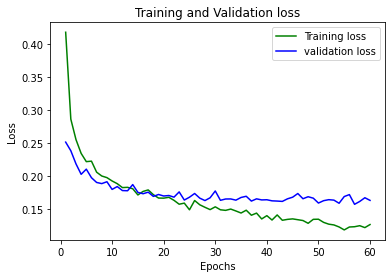

In [282]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,61)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [283]:
model.save("output/model.h5")

In [284]:
result = model.predict(X_testp)

86/86 [==============================] - 0s 485us/step


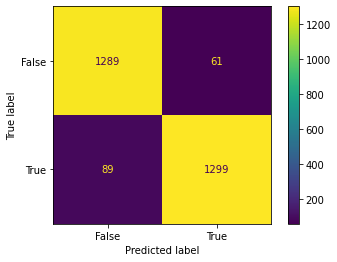

In [285]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, result.round())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

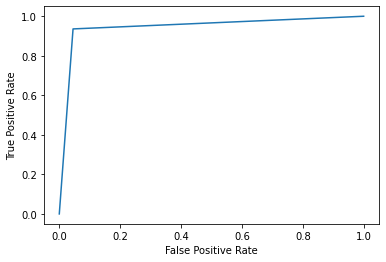

In [286]:
fpr, tpr, _ = metrics.roc_curve(y_test, result.round())

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [80]:
def build_model(hp):
    n_features = X_trainp.shape[1]
    # define model
    model = Sequential()
    model.add(Dense(units=hp.Int('input_units', min_value=32, max_value=256, step=64),
                    activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1,)))

    for i in range(hp.Int("l_layers", min_value=4, max_value=7)):
        model.add(Dense(units=hp.Int(f'unit_{i}', min_value=32, max_value=256, step=64),
                        activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1,)))

    model.add(Dense(1, activation='sigmoid'))
    model.add(BatchNormalization())
    
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-3, max_value=1e-2,
                                                  sampling='LOG', default=1e-3)),
                 loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [81]:
def random_tuner():
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=1,
        directory='random_search',
        project_name='url_10'
    )

    tuner.search(x=X_trainp,
                 y=y_train,
                 epochs=10,
                 batch_size=64,
                 validation_data=(X_testp, y_test))
    
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.fit(X_trainp, y_train, epochs=10, batch_size=64, verbose=2, validation_data=(X_testp, y_test))
    tuner.get_best_hyperparameters()[0].values

In [82]:
#random_tuner()

Trial 20 Complete [00h 00m 04s]
val_accuracy: 0.9207450747489929

Best val_accuracy So Far: 0.9207450747489929
Total elapsed time: 00h 01m 27s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
129/129 - 1s - loss: 0.4471 - accuracy: 0.8718 - val_loss: 0.5223 - val_accuracy: 0.9018 - 1s/epoch - 9ms/step
Epoch 2/10
129/129 - 0s - loss: 0.4108 - accuracy: 0.8584 - val_loss: 0.3750 - val_accuracy: 0.9145 - 301ms/epoch - 2ms/step
Epoch 3/10
129/129 - 0s - loss: 0.4838 - accuracy: 0.8770 - val_loss: 0.5233 - val_accuracy: 0.6596 - 300ms/epoch - 2ms/step
Epoch 4/10
129/129 - 0s - loss: 0.4387 - accuracy: 0.8882 - val_loss: 0.3273 - val_accuracy: 0.9164 - 300ms/epoch - 2ms/step
Epoch 5/10
129/129 - 0s - loss: 0.3877 - accuracy: 0.8945 - val_loss: 0.3313 - val_accuracy: 0.9047 - 297ms/epoch - 2ms/step
Epoch 6/10
129/129 - 0s - loss: 0.3235 - accuracy: 0.9032 - val_loss: 0.2803 - val_accuracy: 0.9182 - 299ms/epoch - 2ms/step
Epoch 7/10
129/129 - 0s - loss: 0.2910 - accuracy: 0.9171 - val_loss: 0.